# !!! Untuk mempercepat model berikutnya bisa run Final Spam Predict Result Saja

# Model 2 - Deteksi Spam/Non-Relevan Ulasan
Akan dilakukan 2 layer model processing. Pertama dengan rule based scoring untuk memprediksi spam/nonspam berdasarkan rule yang ditentukan. Penentuan dilakukan dengan menggunakan weight untuk masing-masing pengecekan. Semakin besar weight yang didapatkan berarti review semakin berpotensi menjadi spam.

Layer 1: Rule-Based Filter
Menyaring junk yang jelas terlihat tanpa perlu masuk ke model AI yang berat.

Layer 2: AI Model (IndoBERT/RoBERTa)
Mendeteksi konteks kalimat yang terlihat valid tapi sebenarnya tidak relevan (misal: komplain kurir).

Install datasketch untuk LSH

In [ ]:
pip install datasketch

## Rule Based Scoring

### Rule Based Scoring with LSH

In [ ]:
import re
import numpy as np
from datasketch import MinHash, MinHashLSH
from typing import List, Dict, Any

class RuleBasedSpamFilter:
    def __init__(self, threshold: int = 50):
        self.THRESHOLD = threshold

        # weights
        # Semakin besar, semakin dianggap SPAM
        self.weights = {
            "is_duplicate": 50,
            "has_url": 60,
            "too_short": 40,
            "repeated_tokens": 20,
            "gibberish": 50
        }

        # LSH untuk deteksi duplikat
        self.lsh = MinHashLSH(threshold=0.8, num_perm=128)
        self.minhashes = {}

    def _get_minhash(self, text: str):
        """Membuat signature MinHash dari teks"""
        m = MinHash(num_perm=128)
        # Shingling (tokenisasi set untuk hash)
        tokens = set(text.split())
        for t in tokens:
            m.update(t.encode('utf8'))
        return m

    def build_lsh_index(self, df_texts: List[str], ids: List[Any]):
        """
        Membangun index LSH dari seluruh dataset.
        Harus dipanggil SEBELUM melakukan scoring per baris.
        """
        print("Building LSH Index for duplicate detection...")
        for i, text in zip(ids, df_texts):
            if not isinstance(text, str) or len(text) < 10:
                continue

            m = self._get_minhash(text)
            self.lsh.insert(str(i), m)
            self.minhashes[str(i)] = m
        print("LSH Index Built.")

    def check_duplicate_lsh(self, doc_id: str) -> bool:
        """Cek apakah dokumen ini punya kembaran di dataset"""
        if str(doc_id) not in self.minhashes:
            return False

        m = self.minhashes[str(doc_id)]
        result = self.lsh.query(m)

        # Jika result > 1, berarti ada yang mirip
        return len(result) > 1

    def calculate_score(self, row, text_col='text_norm', id_col='Unnamed: 0') -> Dict[str, Any]:
        text = str(row[text_col])
        doc_id = row[id_col]

        score = 0
        reasons = []

        # --- 1. Cek Near-Duplicate (LSH) ---
        if self.check_duplicate_lsh(doc_id):
            score += self.weights["is_duplicate"]
            reasons.append("NEAR_DUPLICATE_DETECTED")

        # --- 2. Cek URL ---
        if re.search(r'(http|www|\.com|\.id|wa\.me)', text):
            score += self.weights["has_url"]
            reasons.append("CONTAINS_URL")

        # --- 3. Cek Panjang Kata ---
        tokens = text.split()
        if len(tokens) < 3:
            score += self.weights["too_short"]
            reasons.append("TOO_SHORT")

        # --- 4. Cek Repetisi Token ---
        # Contoh: "barang bagus bagus bagus bagus"
        if len(tokens) > 0:
            unique_tokens = set(tokens)
            if len(unique_tokens) / len(tokens) < 0.4 and len(tokens) > 4:
                score += self.weights["repeated_tokens"]
                reasons.append("REPEATED_TOKENS")

        # --- 5. Cek Gibberish ---
        # Contoh: "klsdjflksjd" (spam)
        if len(text) > 0:
            vowels = len(re.findall(r'[aeiou]', text))
            if vowels == 0 and len(text) > 5:
                 score += self.weights["gibberish"]
                 reasons.append("GIBBERISH_NO_VOWELS")

        confidence = min(score / 100.0, 1.0)

        return {
            "is_spam_layer1": 1 if score >= self.THRESHOLD else 0,
            "spam_score": score,
            "confidence": confidence,
            "reasons": "; ".join(reasons) if reasons else "CLEAN"
        }

import pandas as pd
spam_filter = RuleBasedSpamFilter(threshold=50)
spam_filter.build_lsh_index(df['text_clean'].tolist(), df['Unnamed: 0'].tolist())
results = df.apply(lambda row: spam_filter.calculate_score(row, text_col='text_clean', id_col='Unnamed: 0'), axis=1)
results_df = pd.json_normalize(results)
final_df = pd.concat([df, results_df], axis=1)

print(final_df[['text_clean', 'is_spam_layer1', 'spam_score', 'reasons']])


Building LSH Index for duplicate detection...
LSH Index Built.
                                              text_clean  is_spam_layer1  \
0              barang sesuai pesanan dengan cepat sampai               1   
1                               barang bagus harga murah               1   
2             packing rapi mantap cepat sampai ke tujuan               0   
3                             ya saya puas dengan barang               0   
4                             respon luar biasa b mantap               0   
...                                                  ...             ...   
40602               tidak biasa ditutup ukuran tidak pas               0   
40603  penjual krg peduli dengan barang jelek barang ...               0   
40604  pelayanan kurang siap berhari2 dari nanya baik...               0   
40605  barang yang dikirim tsk sesuai wrn kl memang d...               0   
40606  pihak penjual memberikan respon yang buruk kea...               0   

       spam_score       

Download the result from spam detection using rule based scoring in `spam_detection_results.csv`

In [ ]:
final_df.to_csv('spam_detection_results.csv', index=False)

#### Visualisasi Filtering 1: Rule Based Scoring LSH Matching

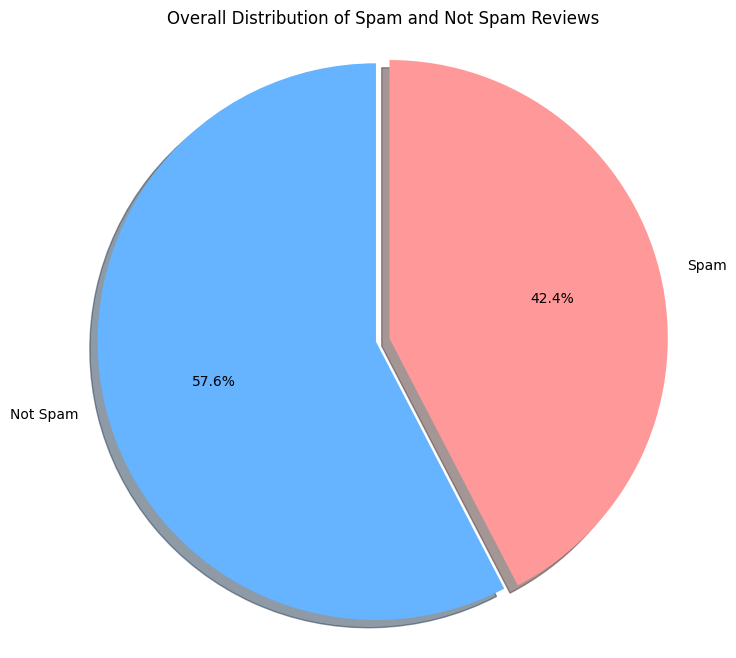

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overall distribution of spam vs. not spam as a pie chart
plt.figure(figsize=(8, 8))
spam_counts = final_df['is_spam_layer1'].value_counts()
labels = ['Not Spam', 'Spam']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)

plt.pie(spam_counts,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
plt.title('Overall Distribution of Spam and Not Spam Reviews')
plt.axis('equal')
plt.show()

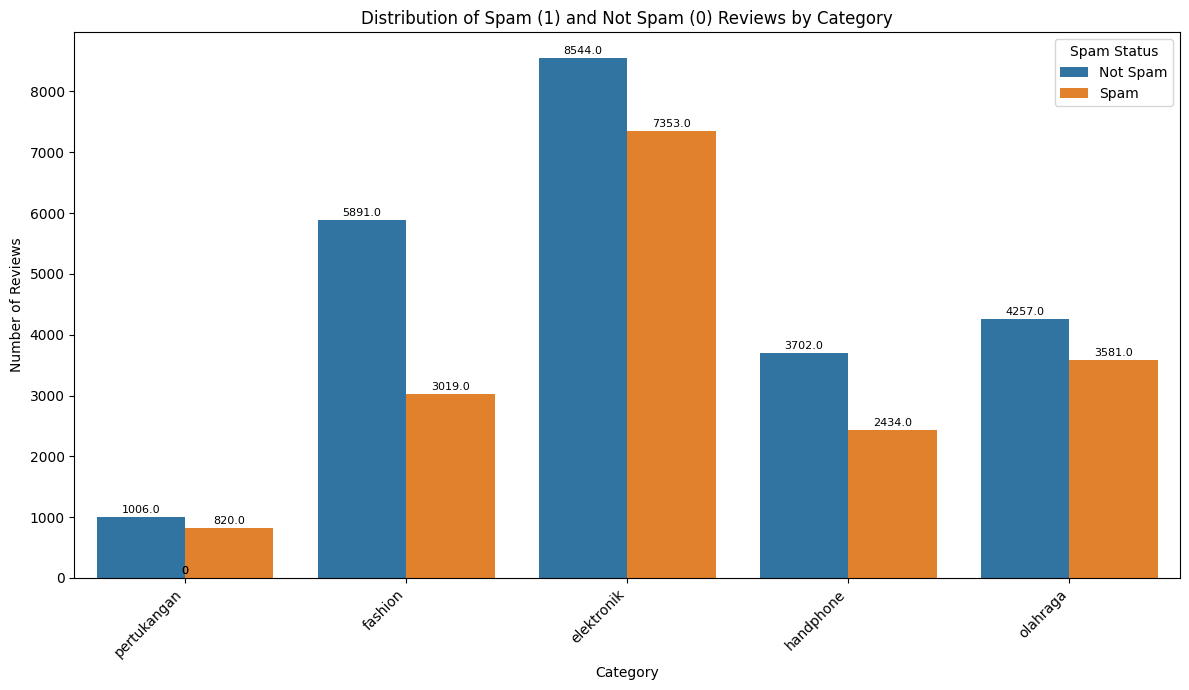

In [ ]:
# Distribution of spam vs. not spam for each category
plt.figure(figsize=(12, 7))
ax2 = sns.countplot(x='category', hue='is_spam_layer1', data=final_df)
plt.title('Distribution of Spam (1) and Not Spam (0) Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Spam Status', labels=['Not Spam', 'Spam'])

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1224082517.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Reason', data=reason_df, palette='viridis')


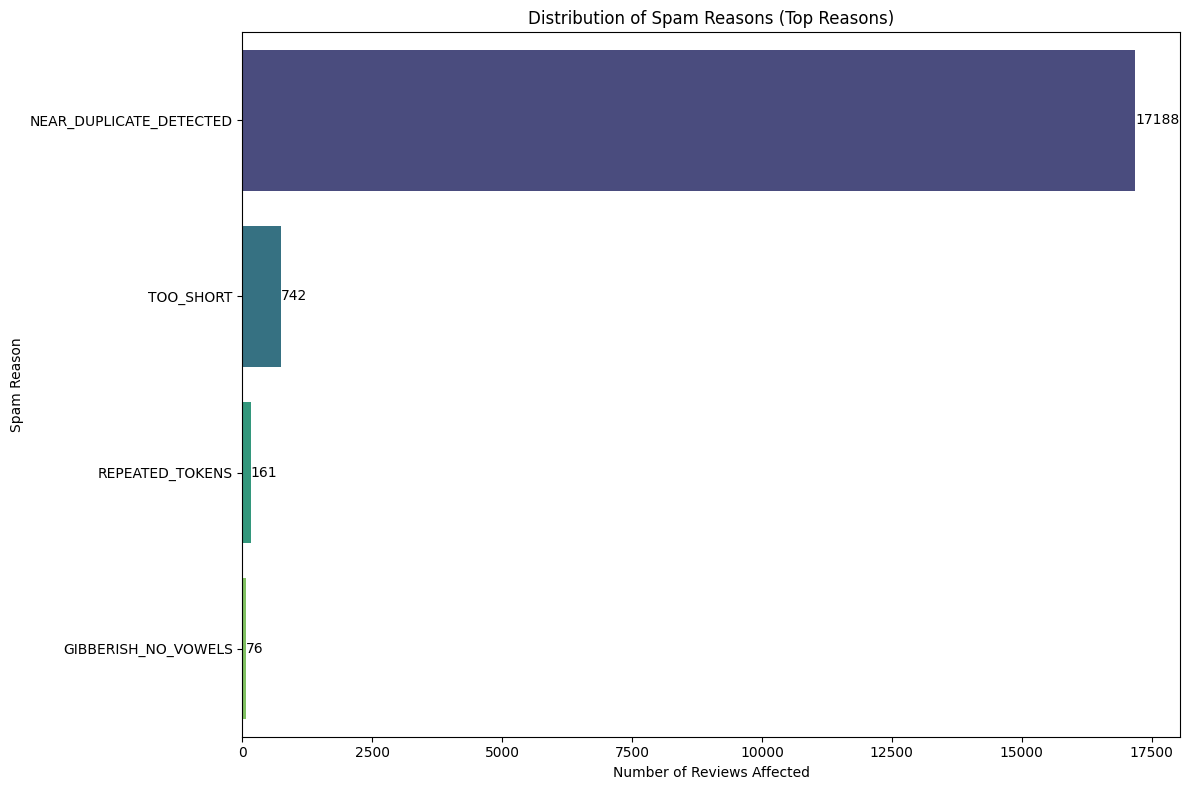

In [ ]:
# Spam labelling reasons distribution
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

spam_reasons_df = final_df[final_df['is_spam_layer1'] == 1]

all_reasons = []
for reasons_str in spam_reasons_df['reasons']:
    if reasons_str and reasons_str != 'CLEAN':
        all_reasons.extend([r.strip() for r in reasons_str.split(';') if r.strip()])

reason_counts = Counter(all_reasons)

reason_df = pd.DataFrame(reason_counts.items(), columns=['Reason', 'Count'])
reason_df = reason_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Reason', data=reason_df, palette='viridis')
plt.title('Distribution of Spam Reasons (Top Reasons)')
plt.xlabel('Number of Reviews Affected')
plt.ylabel('Spam Reason')

for index, row in reason_df.iterrows():
    plt.text(row.Count, index, f'{row.Count}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()

### Rule Based Scoring Exact Matching
Menggunakan Counter untuk menghitung berapa kali sebuah teks muncul. Jika sebuah teks muncul lebih dari 1 kali di dataset (count > 1), maka teks tersebut dianggap memiliki duplikat.

In [ ]:
import re
import pandas as pd
from typing import List, Dict, Any
from collections import Counter

class RuleBasedSpamFilter:
    def __init__(self, threshold: int = 50):
        self.THRESHOLD = threshold

        # weights
        self.weights = {
            "is_duplicate": 100,
            "has_url": 60,
            "too_short": 50,
            "repeated_tokens": 20,
            "gibberish": 50
        }

        # Dictionary untuk menyimpan frekuensi teks
        # Format: { "teks ulasan": jumlah_muncul }
        self.text_counts = {}

    def build_exact_index(self, df_texts: List[str]):
        """
        Menghitung frekuensi kemunculan setiap teks di dataset.
        """
        print("Building Exact Match Index...")
        # Contoh: {"barang bagus": 1, "parah": 5}
        self.text_counts = Counter(df_texts)
        print("Index Built. Total unique texts:", len(self.text_counts))

    def check_duplicate_exact(self, text: str) -> bool:
        """
        Cek apakah teks ini punya duplikat
        """
        # Ambil jumlah kemunculan, default 0 jika error
        count = self.text_counts.get(text, 0)
        return count > 1

    def calculate_score(self, row, text_col='text_clean') -> Dict[str, Any]:
        text = str(row[text_col])

        score = 0
        reasons = []

        # --- 1. Cek Exact Duplicate ---
        if self.check_duplicate_exact(text):
            score += self.weights["is_duplicate"]
            reasons.append("EXACT_DUPLICATE_DETECTED")

        # --- 2. Cek URL ---
        if re.search(r'(http|www|\.com|\.id|wa\.me)', text):
            score += self.weights["has_url"]
            reasons.append("CONTAINS_URL")

        # --- 3. Cek Panjang Kata ---
        tokens = text.split()
        if len(tokens) < 3:
            score += self.weights["too_short"]
            reasons.append("TOO_SHORT")

        # --- 4. Cek Repetisi Token ---
        if len(tokens) > 0:
            unique_tokens = set(tokens)
            if len(unique_tokens) / len(tokens) < 0.4 and len(tokens) > 4:
                score += self.weights["repeated_tokens"]
                reasons.append("REPEATED_TOKENS")

        # --- 5. Cek Gibberish ---
        if len(text) > 0:
            vowels = len(re.findall(r'[aeiou]', text))
            if vowels == 0 and len(text) > 5:
                 score += self.weights["gibberish"]
                 reasons.append("GIBBERISH_NO_VOWELS")

        confidence = min(score / 100.0, 1.0)

        return {
            "is_spam_layer1": 1 if score >= self.THRESHOLD else 0,
            "spam_score": score,
            "confidence": confidence,
            "reasons": "; ".join(reasons) if reasons else "CLEAN"
        }

# --- CARA PENGGUNAAN ---
spam_filter = RuleBasedSpamFilter(threshold=50)

df['text_clean'] = df['text_clean'].astype(str)
spam_filter.build_exact_index(df['text_clean'].tolist())
results = df.apply(lambda row: spam_filter.calculate_score(row, text_col='text_clean'), axis=1)
results_df = pd.json_normalize(results)
final_df = pd.concat([df, results_df], axis=1)
print(final_df[['text_clean', 'is_spam_layer1', 'spam_score', 'reasons']].head(10))

Building Exact Match Index...
Index Built. Total unique texts: 31966
                                          text_clean  is_spam_layer1  \
0          barang sesuai pesanan dengan cepat sampai               1   
1                           barang bagus harga murah               1   
2         packing rapi mantap cepat sampai ke tujuan               0   
3                         ya saya puas dengan barang               0   
4                         respon luar biasa b mantap               0   
5           seller bagus pengiriman cepat barang oke               0   
6                      pengiriman cepat seller bagus               0   
7  produk sesuai dengan spec di web dengan respon...               0   
8  respon super cepat pengiriman cepat barang bag...               0   
9                      barang mantap pelayanan cepat               0   

   spam_score                   reasons  
0         100  EXACT_DUPLICATE_DETECTED  
1         100  EXACT_DUPLICATE_DETECTED  
2           

Download the result from spam detection using rule based scoring in `spam_detection_results.csv`

In [ ]:
final_df.to_csv('spam_detection_results.csv', index=False)

#### Visualisasi Filtering 1: Rule Based Scoring Exact Match

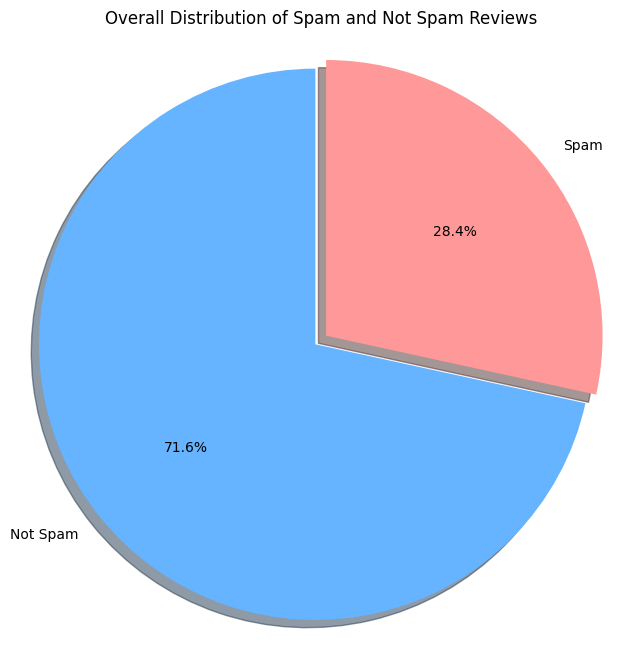

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overall distribution of spam vs. not spam as a pie chart
plt.figure(figsize=(8, 8))
spam_counts = final_df['is_spam_layer1'].value_counts()
labels = ['Not Spam', 'Spam']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)

plt.pie(spam_counts,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
plt.title('Overall Distribution of Spam and Not Spam Reviews')
plt.axis('equal')
plt.show()

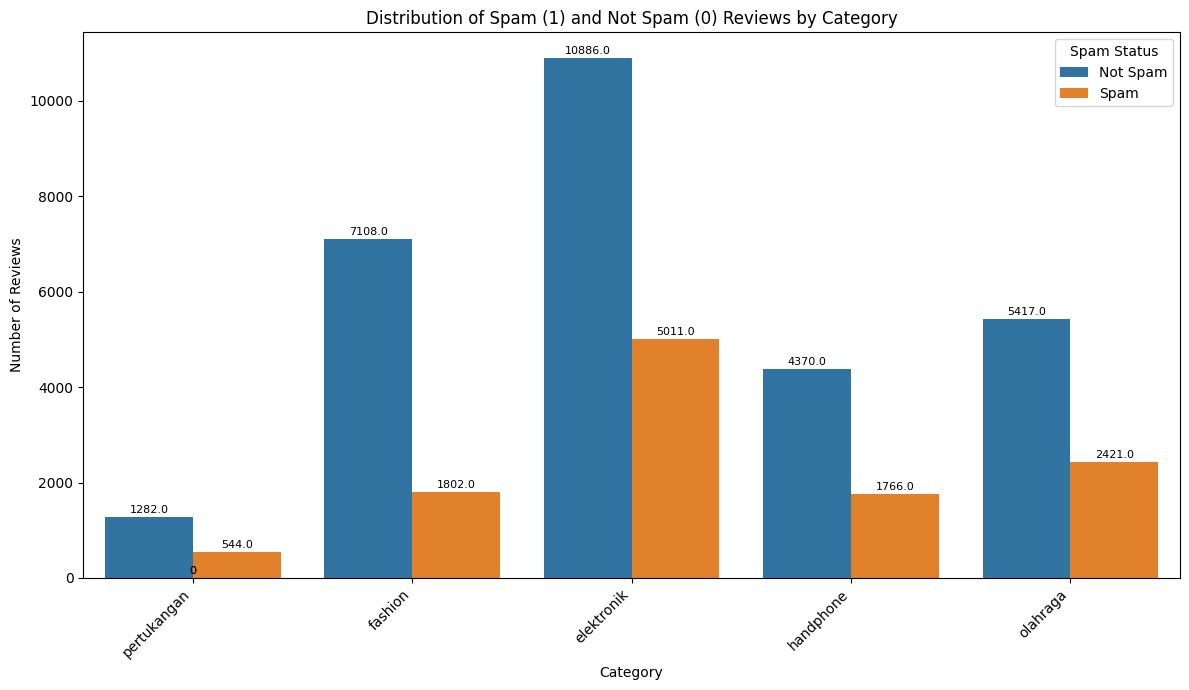

In [ ]:
# Distribution of spam vs. not spam for each category
plt.figure(figsize=(12, 7))
ax2 = sns.countplot(x='category', hue='is_spam_layer1', data=final_df)
plt.title('Distribution of Spam (1) and Not Spam (0) Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Spam Status', labels=['Not Spam', 'Spam'])

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1224082517.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Reason', data=reason_df, palette='viridis')


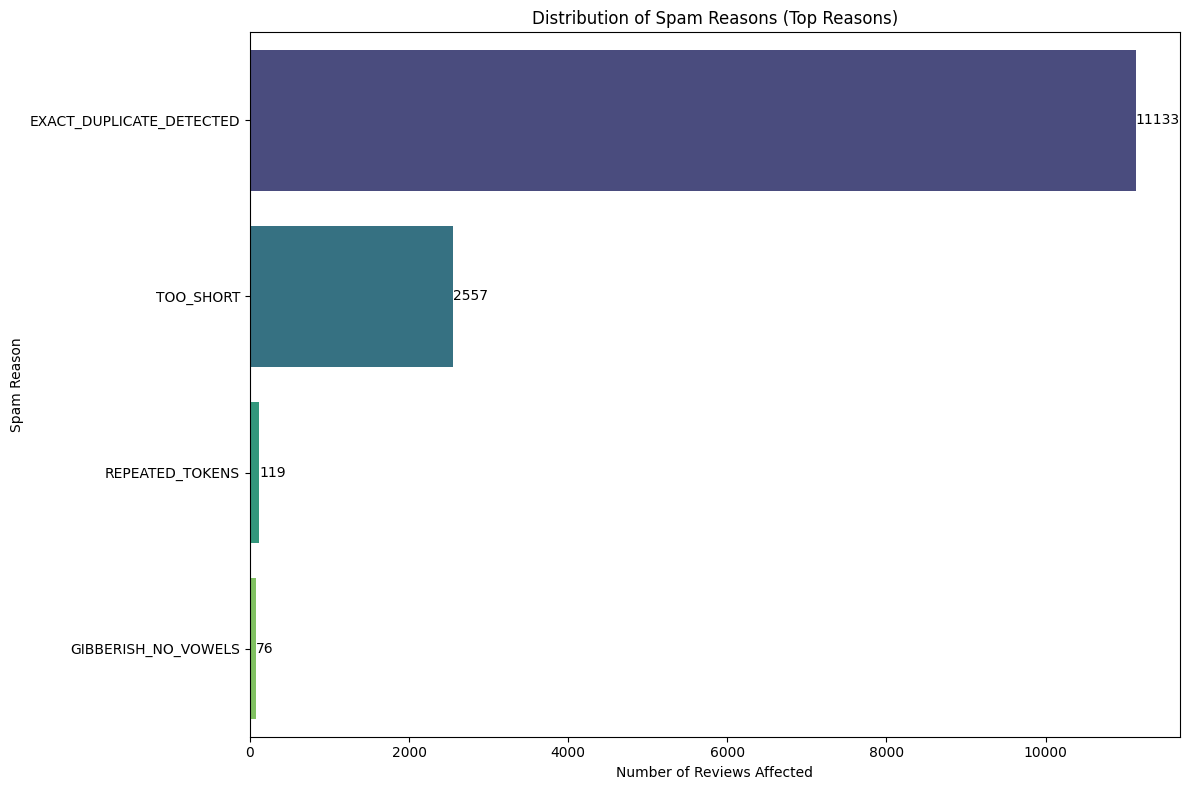

In [ ]:
# Spam labelling reasons distribution
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

spam_reasons_df = final_df[final_df['is_spam_layer1'] == 1]

all_reasons = []
for reasons_str in spam_reasons_df['reasons']:
    if reasons_str and reasons_str != 'CLEAN':
        all_reasons.extend([r.strip() for r in reasons_str.split(';') if r.strip()])

reason_counts = Counter(all_reasons)

reason_df = pd.DataFrame(reason_counts.items(), columns=['Reason', 'Count'])
reason_df = reason_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Reason', data=reason_df, palette='viridis')
plt.title('Distribution of Spam Reasons (Top Reasons)')
plt.xlabel('Number of Reviews Affected')
plt.ylabel('Spam Reason')

for index, row in reason_df.iterrows():
    plt.text(row.Count, index, f'{row.Count}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()

## Model Klasifikasi Biner IndoBERT
Menggunakan pencocokan exact

Pengambilan sampel dari dataset yang digunakan untuk menjadi bahan fine tuning. Setelah pengambilan sampel akan dilakukan manual labelling. Akan dibuat kolom baru manual_label (0 = Relevan, 1 = Spam/Non-Relevan), dan isi manual

In [ ]:
import pandas as pd

# Asumsi df sudah punya kolom 'spam_score' dari proses Layer 1
def get_stratified_sample_for_labeling(df, total_samples=500):
    # 1. Pisahkan berdasarkan bucket score
    df_clean = df[df['spam_score'] == 0]
    df_ambigu = df[(df['spam_score'] > 0) & (df['spam_score'] < 50)]
    df_spam = df[df['spam_score'] >= 50]

    # 2. Tentukan kuota
    n_clean = int(total_samples * 0.4)
    n_ambigu = int(total_samples * 0.4)
    n_spam = int(total_samples * 0.2)

    # 3. Sampling (dengan replace=False agar tidak duplikat, handling jika data kurang)
    sample_clean = df_clean.sample(n=min(len(df_clean), n_clean), random_state=42)
    sample_ambigu = df_ambigu.sample(n=min(len(df_ambigu), n_ambigu), random_state=42)
    sample_spam = df_spam.sample(n=min(len(df_spam), n_spam), random_state=42)

    # 4. Gabungkan dan Shuffle
    df_labeling = pd.concat([sample_clean, sample_ambigu, sample_spam])
    df_labeling = df_labeling.sample(frac=1, random_state=42).reset_index(drop=True)

    # 5. Export ke Excel untuk dilabeli manual
    df_labeling[['text_norm', 'spam_score']].to_excel("data_untuk_labeling.xlsx", index=False)
    print(f"Data siap dilabeli: {len(df_labeling)} baris.")
    return df_labeling

df_to_label = get_stratified_sample_for_labeling(final_df, total_samples=600)

Data siap dilabeli: 440 baris.


Gunakan dataset yang sudah dilabeli untuk training model IndoBERT

In [ ]:
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from difflib import get_close_matches
from collections import Counter

df_labeled = pd.read_excel("https://drive.google.com/uc?id=1oXPhvp9lKhR3q_hSFq516bF2QpdQOpTB&export=download")

if 'manual_label' in df_labeled.columns:
    df_labeled = df_labeled.rename(columns={'manual_label': 'labels'})

# Split Data: Train (80%) & Validation (20%)
train_df, val_df = train_test_split(df_labeled, test_size=0.2, random_state=42, stratify=df_labeled['labels'])

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

if "__index_level_0__" in train_dataset.column_names:
    train_dataset = train_dataset.remove_columns(["__index_level_0__"])
if "__index_level_0__" in val_dataset.column_names:
    val_dataset = val_dataset.remove_columns(["__index_level_0__"])

model_checkpoint = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    texts = [str(t) for t in examples["text_clean"]]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

training_args = TrainingArguments(
    output_dir="./indobert_spam_filter",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("./final_spam_model")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-533044415.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.140265,0.966667,0.846154,0.916667,0.785714
2,No log,0.179770,0.958333,0.827586,0.800000,0.857143
3,No log,0.156520,0.958333,0.814815,0.846154,0.785714


In [ ]:
# Load model yang sudah dilatih
pipeline_model = AutoModelForSequenceClassification.from_pretrained("./final_spam_model")
pipeline_tokenizer = AutoTokenizer.from_pretrained("./final_spam_model")

def get_indobert_prediction(text):
    inputs = pipeline_tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    # Ambil logits dan masukkan ke softmax untuk mendapatkan confidence score
    with torch.no_grad():
        logits = pipeline_model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=1)

    spam_prob = probs[0][1].item() # Probabilitas kelas 1 (Spam)
    return spam_prob

def final_spam_detection(row):
    # STEP 1: Cek Rule Based
    if row['is_spam_layer1'] == 1:
        return {
            "is_spam": 1,
            "confidence": row['confidence'],
            "method": "Rule-Based",
            "reason": row['reasons']
        }

    # STEP 2: Jika Lolos, Cek IndoBERT
    spam_prob = get_indobert_prediction(row['text_norm'])

    # Threshold IndoBERT (misal yakin > 0.5 dianggap spam)
    is_spam_bert = 1 if spam_prob > 0.5 else 0

    return {
        "is_spam": is_spam_bert,
        "confidence": spam_prob if is_spam_bert else (1 - spam_prob),
        "method": "IndoBERT",
        "reason": "Irrelevant Content" if is_spam_bert else "Clean"
    }

final_results = final_df.apply(final_spam_detection, axis=1)

Download the result from spam detection using rule based scoring in `final_spam_result.csv`

In [ ]:
final_results.to_csv('final_spam_result.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_extracted = pd.json_normalize(final_results)
final_df_viz = pd.concat([final_df.reset_index(drop=True), results_extracted], axis=1)
print(final_df_viz[['is_spam', 'method', 'reason', 'confidence']].head())

   is_spam      method                    reason  confidence  confidence
0        1  Rule-Based  EXACT_DUPLICATE_DETECTED         1.0     1.00000
1        1  Rule-Based  EXACT_DUPLICATE_DETECTED         1.0     1.00000
2        0    IndoBERT                     Clean         0.0     0.99708
3        0    IndoBERT                     Clean         0.0     0.99704
4        0    IndoBERT                     Clean         0.0     0.99626


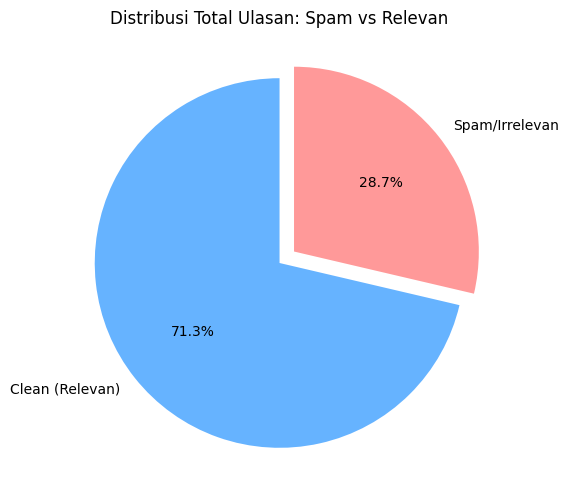

In [ ]:
plt.figure(figsize=(6, 6))

# Hitung jumlah
counts = final_df_viz['is_spam'].value_counts()
labels = ['Clean (Relevan)', 'Spam/Irrelevan']
colors = ['#66b3ff', '#ff9999']

# Buat Pie Chart
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Distribusi Total Ulasan: Spam vs Relevan')
plt.show()

/tmp/ipython-input-467534283.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=spam_only, x='method', palette='viridis')


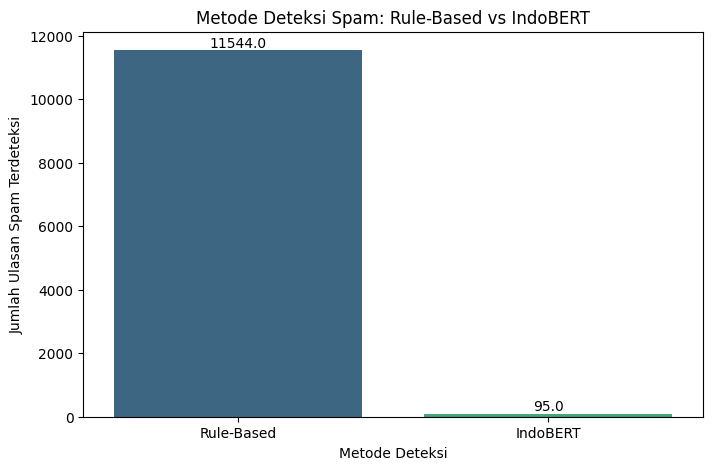

In [ ]:
# Filter hanya data yang SPAM
spam_only = final_df_viz[final_df_viz['is_spam'] == 1]

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=spam_only, x='method', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Metode Deteksi Spam: Rule-Based vs IndoBERT')
plt.xlabel('Metode Deteksi')
plt.ylabel('Jumlah Ulasan Spam Terdeteksi')
plt.show()

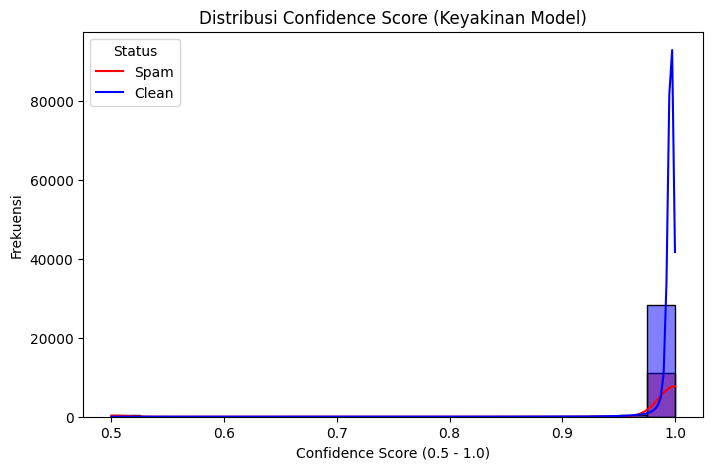

In [ ]:
plt.figure(figsize=(8, 5))

sns.histplot(data=results_extracted, x='confidence', hue='is_spam', kde=True, bins=20, palette={0: 'blue', 1: 'red'})

plt.title('Distribusi Confidence Score (Keyakinan Model)')
plt.xlabel('Confidence Score (0.5 - 1.0)')
plt.ylabel('Frekuensi')
plt.legend(title='Status', labels=['Spam', 'Clean'])
plt.show()

In [ ]:
import pandas as pd

final_df_clean = final_df.reset_index(drop=True)
results_clean = results_extracted.reset_index(drop=True)

combined_df = pd.concat([final_df_clean, results_clean], axis=1)

print(f"Shape final_df: {final_df.shape}")
print(f"Shape results: {results_extracted.shape}")
print(f"Shape Combined: {combined_df.shape}")

combined_df.to_csv('full_merged_data.csv', index=False)

Shape final_df: (40607, 15)
Shape results: (40607, 4)
Shape Combined: (40607, 19)


### Final Spam Predict Result - run this for next models

Gunakan langsung file csv yang di drive agar tidak perlu run seluruh model dari awal. File didapat dari hasil run dan predict model

In [ ]:
df_combined_spam = pd.read_csv(
    "https://drive.google.com/uc?id=1MxEAAtv27aH77ZcnwsyUb27al0l1QWej",
    encoding="latin-1"
)
df_combined_spam.head()

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url,text_clean,text_norm,is_spam_layer1,spam_score,confidence,reasons,is_spam,confidence.1,method,reason
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...,barang sesuai pesanan dengan cepat sampai,barang sesuai pesanan dengan cepat sampai,1,100,1.0,EXACT_DUPLICATE_DETECTED,1,1.00000,Rule-Based,EXACT_DUPLICATE_DETECTED
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,barang bagus harga murah,barang bagus harga murah,1,100,1.0,EXACT_DUPLICATE_DETECTED,1,1.00000,Rule-Based,EXACT_DUPLICATE_DETECTED
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,packing rapi mantap cepat sampai ke tujuan,packing rapi mantap cepat sampai ke tujuan,0,0,0.0,CLEAN,0,0.99708,IndoBERT,Clean
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...,ya saya puas dengan barang,ya saya puas dengan barang,0,0,0.0,CLEAN,0,0.99704,IndoBERT,Clean
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...,respon luar biasa b mantap,respon luar biasa b mantap,0,0,0.0,CLEAN,0,0.99626,IndoBERT,Clean


# Model 3 -